## Trump Twitter Analysis
# Group 14: MDS 522 : Members: <br> Quan Hoang, Mailys Guegon, Joel Peterson, Li Pu 
Analyzing the <b>realDonaldTrump_in_office.csv </b>
from https://github.com/MarkHershey/CompleteTrumpTweetsArchive/blob/master/data/realDonaldTrump_in_office.csv

# Summary
Here we are analyzing Tweets published by Donald Trump during his first presidency, specifically how the time of day or season affect the frequency of the tweets. Additionally, we did sentiment analysis using a VADER for classification to determine the frequency of positive, negative and neutral tweets. Finally, using a combination of CountVectorizer and Logistic Regression, we used WorldCloud visualization to determine the most frequent positive and negative words.

## Introduction
Twitter (also known as X) is one of the world's most popular social media platforms, where users can share short messages (texts, videos, photos) known as tweets.
In April 2025, the Pew Research Center did a study and found that on average active users published 157 tweets per month, which is around 5 tweets per day. At the beginning of his first presidency, Donald Trump followed the average, posting about 5.7 times per day. However towards the second half of 2020, his posting rate grew to around 34.8 times per day. On June 5 2020, he went as far as tweeting or retweeting 200 messages in a single day. With so much data, we though it would be interesting to consider what could affect his frequency of posting. The president uses the platform mostly to disparage those he perceives as threats (people, companies, countries...), with more than half of his tweets between January 2017 and October 2019 being used to attack something or someone. Another intresting question to consider would be to determine the frequency of positive and negative tweets throughout his presidency. In this report, we will start by considering different  the factors (time of day or season) that might have an impact on the frequency of the tweets, then we will classify the tweets into positive, negative or neutral to determine the most frequent sentiment expressed in his posts. 

## Data
The dataset we are using contains all tweets published (includes deleted tweets) published by Donald Trump during his first presidency between 20 Jan 2017 and 08 Jan 2021. It contains 5 columns (ID, Time, Tweet URL, Tweet Text) and each row represents a tweet.
For the initial EDA and data processing we ended up having to drop around 1/2 of the rows to stop unconventional characters at the end of the tweet string from tripping up pandas. After a visual review we noticed that these problem rows were quite evenly distributed (every 2-3 rows) and that this wouldn't be too much of an issue to get started.

## Analysis


### Part 1: Does the time of day/period of the year affect the frequency of the tweets?

With the president posting 34.8 times per day it is interesting to consider whether the time of day or even the period of the year affects the frequency of his tweets. <br>
Before our analysis, we believed that the frequency of tweets would be highest during the daytime and night-time. These assumptions were proven wrong as the numbers show that the most frequent time of day for tweets was the overnight period. 

In [1]:
import pandas as pd
import altair as alt
import requests
import pandera as pa
from pandera import Column, DataFrameSchema

def load_clean_trump_csv(url):                # chatGPT assistance to construct this data-cleaning function from URL
    resp = requests.get(url)                   # download the csv text from passed URL
    resp.raise_for_status()                     # raise if 4xx/5xx
    lines = resp.text.splitlines()

    rows = []

    for i, line in enumerate(lines, start=1):
        line = line.rstrip("\n\r")
        if not line.strip():
            continue                                   # skip empty lines

        parts = line.split(",")

        if i == 1:                                        # skip header row => define custom column names later
            continue

        if len(parts) < 4:                                  # if fewer than 4 parts => it's truly broken => drop
            continue

        id_val = parts[0].strip()                              # the first 3 columns don't need cleaning
        time_val = parts[1].strip()
        url_val = parts[2].strip()
        tweet_text = ",".join(parts[3:]).strip()

        rows.append((id_val, time_val, url_val, tweet_text))

    df = pd.DataFrame(rows, columns=["ID", "Time", "Tweet URL", "Tweet Text"])
    return df


url = "https://raw.githubusercontent.com/MarkHershey/CompleteTrumpTweetsArchive/refs/heads/master/data/realDonaldTrump_in_office.csv"

tweets = load_clean_trump_csv(url)

tweets.columns = tweets.columns.str.strip()                         # strip white-space from before column names 
#print(tweets.columns)
tweets["Date & Time"] = pd.to_datetime(tweets["Time"], errors="coerce")     # set Time column to DateTime and rename
tweets = tweets.drop(columns=["ID", "Tweet URL", "Time"])                     # drop ID => twitter-handle, Tweet URL, Time => now "Date & Time"

print(tweets.shape)
tweets.head(10)

(23075, 2)


,Tweet Text,Date & Time
0,"""It all begins today! I will see you at 11:00 ...",2017-01-20 06:31:00
1,"""Today we are not merely transferring power fr...",2017-01-20 11:51:00
2,"""power from Washington, D.C. and giving it bac...",2017-01-20 11:51:00
3,"""What truly matters is not which party control...",2017-01-20 11:52:00
4,"""January 20th 2017, will be remembered as the ...",2017-01-20 11:53:00
5,"""The forgotten men and women of our country wi...",2017-01-20 11:54:00
6,"""We will bring back our jobs. We will bring ba...",2017-01-20 11:54:00
7,"""We will follow two simple rules: BUY AMERICAN...",2017-01-20 11:55:00
8,"""It is time to remember that...https://www.fac...",2017-01-20 11:58:00
9,"""So to all Americans, in every city near and f...",2017-01-20 12:00:00


In [2]:
schema = DataFrameSchema(
    {
        "Date & Time": Column(pa.DateTime, nullable=False, coerce=True),
        "Tweet Text": Column(pa.String, nullable=False),
    }
)

tweets_valid = schema.validate(tweets)

/Users/mailysguedon/miniforge3/envs/522_proj/lib/python3.12/site-packages/pandera/_pandas_deprecated.py:149: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


-  The initial data filtering by time of day visualized in the bar chart shows that the highest frequency of tweets occurs during the evening period between 4:01 pm - 12:00 am (as mentioned above) with a total of 8825 analyzed tweets. The second most frequent tweet period occurred during the overnight period between  12:01 am - 8:00 am with a total of 7881 analyzed tweets, with the time of day resulting in the least frequent amount of tweets actually being the daytime period between 8:01am-4:00pm with a total of 6369 analyzed tweets. Perhaps this is because Trump is most busy during the day (golfing?) and cannot tend to tweets.

In [3]:
tweets = tweets.set_index("Date & Time")                                  # set index to DateTime for filtering 


daytime = tweets.between_time("08:01", "16:00")                             # 8:01 am - 4:00 pm
evening = tweets.between_time("16:01", "00:00")                              # 4:01 pm - 12:00 am
overnight = tweets.between_time("00:01", "08:00")                             # 12:01 am - 8:00 am

print(f"The number of tweets in the 'Daytime' category is: {len(daytime)}")
print(f"The number of tweets in the 'Evening' category is: {len(evening)}")
print(f"The number of tweets in the 'Overnight' category is: {len(overnight)}")

print("Just by the distribution of tweets it is surprisingly evenly spread; with the most tweets happening in the evening.")



The number of tweets in the 'Daytime' category is: 6369
The number of tweets in the 'Evening' category is: 8825
The number of tweets in the 'Overnight' category is: 7881
Just by the distribution of tweets it is surprisingly evenly spread; with the most tweets happening in the evening.


In [4]:
tweet_time = pd.DataFrame({
    "Time": ["daytime", "evening", "overnight"],
    "Count": [len(daytime), len(evening), len(overnight)]
})

tweet_time

,Time,Count
0,daytime,6369
1,evening,8825
2,overnight,7881


Figure 1: Number of tweets published by time of day (daytime: 8:01 am - 4:00 pm, evening: 4:01 pm - 12:00 am, overnight: 12:01 am - 8:00 am )


-  The seasonal filtering of the tweets returned the results of the most frequent amount of tweets being in the summer with 6747 analyzed tweets, with the autumn being the second busiets season for tweets resulting in 6401 analysed tweets, followed by the spring recording 5543 analyzed tweets, and lastly the winter being the least busy season for tweets recording a number of 4384 tweets. This falls inline with inutitive assumptions about mood and activity as the summer is usually the busiest with longer days (daylight) and nicer weather, then the fall slowly tapers off into the winter season being the shortest days for daylight and the most restricting weather.


In [5]:
tw = pd.Series(tweets.index.strftime('%m-%d'), index=tweets.index)     # ChatGPT assistance to troubleshoot filtering datetimes in index

spring = tweets.loc[tw.between('04-01', '06-30')]                    # April 1st - June 30th
summer = tweets.loc[tw.between('07-01', '09-30')]                   # July 1st - September 30th
autumn = tweets.loc[tw.between('10-01', '12-31')]                  # October 1st - December 31st
winter = tweets.loc[tw.between('01-01', '03-31')]                 # January 1st - March 31st 

print(f"The number of tweets in the 'Spring' category is: {len(spring)}")
print(f"The number of tweets in the 'Summer' category is: {len(summer)}")
print(f"The number of tweets in the 'Autumn' category is: {len(autumn)}")
print(f"The number of tweets in the 'Winter' category is: {len(winter)}")
print("")
print("Judging by the distribution of tweets throughout the seasons, the frequency decays in the winter and spring and peaks in the summer")


The number of tweets in the 'Spring' category is: 5543
The number of tweets in the 'Summer' category is: 6747
The number of tweets in the 'Autumn' category is: 6401
The number of tweets in the 'Winter' category is: 4384

Judging by the distribution of tweets throughout the seasons, the frequency decays in the winter and spring and peaks in the summer


In [6]:
tweet_season = pd.DataFrame({
    "Season": ["Spring", "Summer", "Autumn", "Winter"],
    "Count": [len(spring), len(summer), len(autumn), len(winter)]
})

tweet_season

,Season,Count
0,Spring,5543
1,Summer,6747
2,Autumn,6401
3,Winter,4384


Figure 2: Number of tweets published by season (Spring: April 1st - June 30th, Summer: July 1st - September 30th, Autumn: October 1st - December 31st, Winter: January 1st - March 31st)


Creating the time of day frequency charts:

In [7]:
time_bars = alt.Chart(tweet_time).mark_bar(color="#f00808").encode(
    y = "Time:N", 
    x = "Count:Q",
    ).properties(
    title="Trump's Tweet Frequency by Time of Day",
    width=500,
    height=350)

#time_bars

In [8]:
label_df = pd.DataFrame({
    "Time": ["daytime", "evening", "overnight"],
    "range": ["8:01am–4:00pm", "4:01pm–12:00am", "12:01am–8:00am"],
    "Count": tweet_time["Count"].values
})

In [9]:
range_text = (
    alt.Chart(label_df)
    .mark_text(
        align="center",
        baseline="middle",
        color="white",
        fontSize=16,
        dx=-80
    )
    .encode(
        y="Time:N",
        x="Count:Q",
        text="range:N"
    )
)

#time_bars + range_text

In [10]:
count_text = alt.Chart(label_df).mark_text(
    align="left",
    baseline="middle",
    dx=5,
    color="black",
    fontSize=14
).encode(
    y="Time:N",
    x="Count:Q",      
    text="Count:Q"
)

tweet_times = time_bars + range_text + count_text
#tweet_times

In [11]:
final_time_of_day_chart = (time_bars + range_text + count_text).properties(padding={"right": 50, "top":15, "bottom":15, "left":10})   # <= add some white-space to balance appearance
final_time_of_day_chart

alt.LayerChart(...)

Figure 3: Trump's Tweet Frequency by Time of Day


Creating the seasonal frequency charts:

In [12]:
season_bars = alt.Chart(tweet_season).mark_bar(color="#f00808").encode(
    x="Count:Q",
    y=alt.Y("Season:N",sort=["Spring", "Summer", "Autumn", "Winter"])
    ).properties(
    title="Trump's Tweet Frequency by Season",
    width=500,
    height=350)

#season_bars

In [13]:
season_label_df = pd.DataFrame({
    "Season": ["Spring", "Summer", "Autumn", "Winter"],
    "range": ["April 1st - June 30th", "July 1st – Sept 30th", "Oct 1st – Dec 31st", "Jan 1st - March 31st"],
    "Count": tweet_season["Count"].values
})
#season_label_df

In [14]:
season_range_text = alt.Chart(season_label_df).mark_text(
        align="center",
        baseline="middle",
        color="white",
        fontSize=16,
        dx=-90
    ).encode(
        y=alt.Y("Season:N",sort=["Spring", "Summer", "Autumn", "Winter"]),
        x="Count:Q",
        text="range:N"
    )

#season_bars + season_range_text

In [15]:
season_count_text = alt.Chart(season_label_df).mark_text(
    align="left",
    baseline="middle",
    dx=5,
    color="black",
    fontSize=14
).encode(
    y=alt.Y("Season:N",sort=["Spring", "Summer", "Autumn", "Winter"]),
    x="Count:Q",      
    text="Count:Q"
)

tweet_seasons = season_bars + season_range_text + season_count_text
#tweet_seasons

In [16]:
final_season_chart = (season_bars + season_range_text + season_count_text).properties(padding={"right": 50, "top":15, "bottom":15, "left":10})  # aesthetic padding 

final_season_chart

alt.LayerChart(...)

Figure 4: Trump's Tweet Frequency by Season


Visualizing our results we see that there is no major difference in posting frequency given the time of day, but there is a difference for different seasons.

In [17]:
tweet_charts = (tweet_seasons | tweet_times).properties(padding={"right": 50, "top":25, "bottom":25, "left":25}) 
tweet_charts

alt.HConcatChart(...)

Figure 5: Trump's Tweet Frequency by Time of Day and Season 


### Part 2: How many tweets are positive vs negative? (2 classification methods)
When we think of the tweets posted by the president, we tend to think mostly of those where he critices or attacks others. However, is this a real representation of the sentiments of his tweets? In this part we will use two different sentiment analysis models to determine the frequency of positive, negative and neutral tweets.

<b> Method 1:</b>  
We use a simple sentiment analysis model (VADER) to classify each tweet as positive, negative, or neutral, and then compare the counts, this methodological inspiration is from ChatGPT.


In [18]:
#import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


In [19]:
tweets_q2 = tweets.copy()
tweets_q2["Tweet Text"] = tweets_q2["Tweet Text"].fillna("").astype(str)

tweets_q2["sentiment_score"] = tweets_q2["Tweet Text"].apply(
    lambda t: sia.polarity_scores(t)["compound"]
)

def score_to_label(score, pos_threshold=0.05, neg_threshold=-0.05):
    if score >= pos_threshold:
        return "positive"
    elif score <= neg_threshold:
        return "negative"
    else:
        return "neutral"

tweets_q2["sentiment_label"] = tweets_q2["sentiment_score"].apply(score_to_label)

tweets_q2[["Tweet Text", "sentiment_score", "sentiment_label"]].head(10)


,Tweet Text,sentiment_score,sentiment_label
Date & Time,,,
2017-01-20 06:31:00,"""It all begins today! I will see you at 11:00 ...",0.0000,neutral
2017-01-20 11:51:00,"""Today we are not merely transferring power fr...",0.2144,positive
2017-01-20 11:51:00,"""power from Washington, D.C. and giving it bac...",0.3400,positive
2017-01-20 11:52:00,"""What truly matters is not which party control...",0.0954,positive
2017-01-20 11:53:00,"""January 20th 2017, will be remembered as the ...",0.0000,neutral
2017-01-20 11:54:00,"""The forgotten men and women of our country wi...",-0.6124,negative
2017-01-20 11:54:00,"""We will bring back our jobs. We will bring ba...",0.7345,positive
2017-01-20 11:55:00,"""We will follow two simple rules: BUY AMERICAN...",0.0000,neutral
2017-01-20 11:58:00,"""It is time to remember that...https://www.fac...",0.0000,neutral


In [20]:

sentiment_counts = (
    tweets_q2
      .groupby("sentiment_label")
      .size()
      .reset_index(name="Count")   
      .rename(columns={"sentiment_label": "Sentiment"})  
)

sentiment_counts

,Sentiment,Count
0,negative,6839
1,neutral,4400
2,positive,11836


Figure 6: Number of tweets per sentiment (negative, neutral, positive)


Using the VADER sentiment analyzer the tweets were classified as either positive, neutral, or negative. At first, we believed that the tweets were likely more negative than positive, but in fact the tweets were classified as far more positive than negative, almost doubling the negatively classified tweets. The tweets classified as 'neutral' fall almost directly in between the tweets classified as positive and negative. The actual context and literal meaning of the tweets was not analyzed, nor the accuracy of the classification at this point, so there is certainly going to be a margin of error and some 'false positives' etc as the positivity is quite often a self directed compliment of sorts.

In [21]:
sentiment_chart = (
    alt.Chart(sentiment_counts)
    .mark_bar()
    .encode(
        x=alt.X("Sentiment:N", sort=["positive", "neutral", "negative"]),
        y=alt.Y("Count:Q"),
        tooltip=["Sentiment", "Count"]
    )
    .properties(
        title="Number of Positive, Neutral, and Negative Tweets"
    )
)

sentiment_chart


alt.Chart(...)

Figure 7: Chart Comparing the Number of Positive, Neutral, and Negative Tweets

<b> Method 2:</b>   
Using a CountVectorizer and Logistic Regression, combining with a Wordcloud visualization to determine the most frequent words in the positive and negative tweets. Syntax and bug fixing credited to ChatGPT 5.1 <br>



Number of weak labeled tweets: 10136
weak_label
positive    6067
negative    4069
Name: count, dtype: int64
Validation accuracy (weak labels): 0.9990138067061144
Sentiment
positive    16013
negative     7062
Name: count, dtype: int64

Most frequent words in positive tweets:
          word  count
0        great   3590
1    president   1882
2        thank   1538
3        trump   1398
4          big   1174
5      america   1026
6        today    954
7      country    932
8          new    893
9           no    847
10        news    840
11    american    814
12         get    802
13         out    761
14        good    739
15  whitehouse    723
16          up    723
17        many    693
18        been    677
19       there    641

Most frequent words in negative tweets:
         word  count
0   democrats   1602
1       trump   1084
2   president   1058
3       biden   1011
4          no    993
5        fake    743
6         joe    723
7        news    694
8       would    652
9         ou

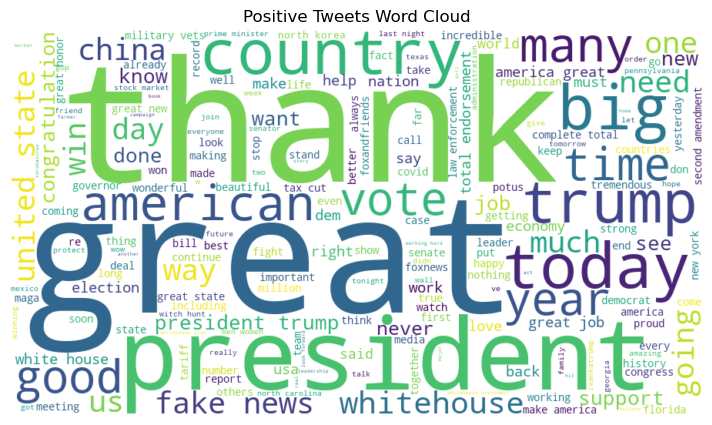

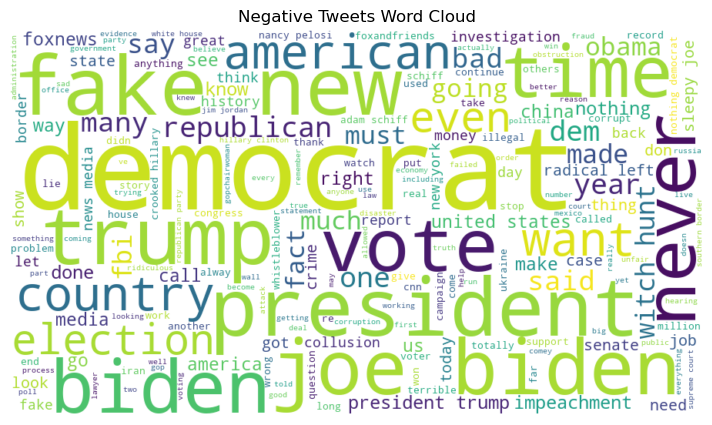

In [22]:
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

positive_words = set("""good great amazing fantastic tremendous strong win winning beautiful success successful
happy proud respect love best positive incredible honored grateful huge strong strongest great big""".split())

negative_words = set("""bad terrible horrible weak fail failure disaster sad angry corrupt
worst negative unfair hate disgrace stupid dishonest democrat biden obama democrats sleepy joe illegal""".split())  # democrat, biden, obama usually associated negatively when Trump speaks

stopwords = set("""the a an and of to in is it this that for on with be as by are was were will from at have has but not or if so
you your my our their they we i he she his her him them rt s all t just now amp more very about do what who people word should m realdonaldtrump u""".split())

# -------------------------------------------------------------------
# 1. Helper functions
# -------------------------------------------------------------------

def simple_tokenize(text: str):
    """Lowercase everything, remove URLs and non letters, then split."""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)          # remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)        # keep letters and spaces
    return text.split()

def weak_label(text: str):
    """Use positive and negative lexicons to create weak labels for training."""
    if not isinstance(text, str):
        return None
    tokens = simple_tokenize(text)
    pos_hits = sum(1 for w in tokens if w in positive_words)
    neg_hits = sum(1 for w in tokens if w in negative_words)
    if pos_hits > neg_hits:
        return "positive"
    elif neg_hits > pos_hits:
        return "negative"
    else:
        return None  # ambiguous, skip from training

# -------------------------------------------------------------------
# 2. Create weak labels for a subset of tweets
# -------------------------------------------------------------------

tweets["weak_label"] = tweets["Tweet Text"].apply(weak_label)
train_df = tweets.dropna(subset=["weak_label"]).copy()

print("Number of weak labeled tweets:", len(train_df))
print(train_df["weak_label"].value_counts())

# -------------------------------------------------------------------
# 3. Train a simple ML model using CountVectorizer
# -------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    train_df["Tweet Text"],
    train_df["weak_label"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["weak_label"]
)

vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=3)
X_train_vec = vectorizer.fit_transform(X_train.fillna(""))
X_test_vec = vectorizer.transform(X_test.fillna(""))

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_vec, y_train)

print("Validation accuracy (weak labels):", clf.score(X_test_vec, y_test))

# -------------------------------------------------------------------
# 4. Predict sentiment for all tweets (positive vs negative)
# -------------------------------------------------------------------

all_X = vectorizer.transform(tweets["Tweet Text"].fillna(""))
tweets["Sentiment"] = clf.predict(all_X)

print(tweets["Sentiment"].value_counts())

# -------------------------------------------------------------------
# 5. Answer the question "What are the most frequent words in the positive and negative tweets?"
# -------------------------------------------------------------------

pos_text = " ".join(tweets[tweets["Sentiment"] == "positive"]["Tweet Text"].dropna())
neg_text = " ".join(tweets[tweets["Sentiment"] == "negative"]["Tweet Text"].dropna())

pos_tokens = [w for w in simple_tokenize(pos_text) if w not in stopwords]
neg_tokens = [w for w in simple_tokenize(neg_text) if w not in stopwords]

top_pos = Counter(pos_tokens).most_common(20)
top_neg = Counter(neg_tokens).most_common(20)

top_pos_df = pd.DataFrame(top_pos, columns=["word", "count"])
top_neg_df = pd.DataFrame(top_neg, columns=["word", "count"])

print("\nMost frequent words in positive tweets:")
print(top_pos_df)

print("\nMost frequent words in negative tweets:")
print(top_neg_df)

# -------------------------------------------------------------------
# 6. Wordcloud
# -------------------------------------------------------------------
pos_wc = WordCloud(
    width=900,
    height=500,
    background_color="white"
).generate(" ".join(pos_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(pos_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Tweets Word Cloud")
plt.show()

neg_wc = WordCloud(
    width=900,
    height=500,
    background_color="white"
).generate(" ".join(neg_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(neg_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Tweets Word Cloud")
plt.show()

Figure 8a: Table with the number of weak labeled tweets <br>
Figure 8b: Table with the number of tweets per sentiment (positive or negative) <br>
Figure 8c: Table of the most frequent words used in positive tweets <br>
Figure 8d: Word cloud of the positive tweets <br>
Figure 8e: Word cloud of the negative tweets <br>


The second classifier method used to analyze the tweets was utilizing the CountVectorizer() to classify sets as positive words, negative words and some stop words unique to this dataset. The overall positive VS negative tweet counts are skewed in the opposite direction as the 'neutral' category here is somewhat added to the postively classified category. The results of the most frequent words are not very surprising to anyone who has followed American news at all in the last 10 years with the positive tweets containing words of praise and common phrases used by Trump, as well as his own name. The most frequent words appearing in the negative tweets could also be somewhat assumed as they contain words of the opposing political parties and leaders as well as other common phrases and words that one would hear often in a news report of Trump lashing out over twitter or a speech. A somewhat interesting note is that the word 'Trump' appears frequently in both positive and negative classifications, but could be rationalized by the fact that Trump often speaks about himself in the third person. A great visual indicator of these word frequencies is the word clouds for the respective most frequent positive and negatively classified words. 

### Target/response variable follows expected distribution validation: 
For this question, since the dataset we used did not have a "target" column, we had to try using different methods in order to find the "sentiment" of the tweets (this has been discussed with Instructor Sky Sheng and she gave us the go ahead. As the graphs/values of the check for usiing CountVectorizer and Logistic Regression below suggest, we do see a skewness towards positive tweets, which can be surprising to many people. This is partly due to neutral tweets are lumped together with positive tweets. However, since this dataset is about Trump's tweets while he was in office, those tweets could be positive because he was the "powerful man" back then. 

In [23]:
# -------------------------------------------------------------------
# Data validation related to target
# -------------------------------------------------------------------
import seaborn as sns
# -------------------------------------------------------------------
# 1. Distribution of Sentiment Graph
# -------------------------------------------------------------------
sns.countplot(data=tweets, x="Sentiment")
plt.title("Distribution of Sentiment Labels")
plt.show()
# -------------------------------------------------------------------
# 2. Distribution of Sentiment Proportion
# -------------------------------------------------------------------
print(tweets["Sentiment"].value_counts(normalize=True))
# -------------------------------------------------------------------
# 3. Time-based Distribution of Sentiment Graph
# -------------------------------------------------------------------
tweets.resample("M")["Sentiment"].value_counts().unstack().plot(kind="bar", figsize=(12,5))
plt.title("Sentiment over time (monthly)")
plt.show()


ModuleNotFoundError: No module named 'seaborn'

Figure 9a: Graph with the distribution of sentiment labels <br>
Figure 9b: Proportion of sentiment labels values <br>
Figure 9c: Graph with the distribution of sentiment labels over time <br>

### No anomalous correlations between target/response variable and features/explanatory variables validation: 
For this question, again since the dataset we used did not have a "target" column, we tried our best to validate what was done. We can see that negative tweets has a higher mean length compared to positive tweets. However, there is no real correlation between time of day (even though negative tweets seem to appear slightly later in the day) or day of the week. In the wordclouds above, we do not see a clear intersection of words both appearing frequently in positive tweets and negative tweets which shows that our classification is working quite well. Last but not least, the model probability distribution graph shows that the model confidently picked up positive and negative tweets while still showing uncertainty for ambiguous cases, which is expected for a simple classifier trained on weak, lexicon-based labels. 

In [ ]:
# -------------------------------------------------------------------
# Data validation related to target pt.2
# -------------------------------------------------------------------

# -------------------------------------------------------------------
# 1. Numeric correlations
# -------------------------------------------------------------------
tweets["length"] = tweets["Tweet Text"].str.len()
print(tweets.groupby("Sentiment")["length"].describe())
# -------------------------------------------------------------------
# 2. Categorical correlations (hour of day, weekday)
# -------------------------------------------------------------------
tweets["hour"] = tweets.index.hour
tweets["weekday"] = tweets.index.dayofweek
sns.boxplot(data=tweets, x="Sentiment", y="hour")
plt.show()
sns.boxplot(data=tweets, x="Sentiment", y="weekday")
plt.show()
# -------------------------------------------------------------------
# 3. Model probability checks
# -------------------------------------------------------------------
probs = clf.predict_proba(vectorizer.transform(tweets["Tweet Text"]))
tweets["pos_prob"] = probs[:, 1]
sns.histplot(tweets["pos_prob"])
plt.title("Prediction Probability Distribution")
plt.show()

Figure 10a: Tweet length stats according to sentiments <br>
Figure 10b: Distribution graphs for time of day and day of the week related to sentiments <br>
Figure 10c: Model prediction probability distribution graph <br>

### Correct category levels

#### Checking for string mismatches

In [24]:
# Using pandera
import pandera as pa
from deepchecks.tabular.checks import StringMismatch

schema = pa.DataFrameSchema(
    {  
        "Sentiment": pa.Column(str,
                               pa.Check.isin(["positive","negative"],error="There is a string mismatch. The correct levels are positive or negative.")),
        "weak_label": pa.Column(str, pa.Check.isin(["positive","negative"], error="The category levels are not correct (string mismatch)."), nullable=True)
    }

)

schema.validate(tweets,lazy=True)

/Users/mailysguedon/miniforge3/envs/522_proj/lib/python3.12/site-packages/deepchecks/core/serialization/dataframe/html.py:16: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



,Tweet Text,weak_label,Sentiment
Date & Time,,,
2017-01-20 06:31:00,"""It all begins today! I will see you at 11:00 ...",None,positive
2017-01-20 11:51:00,"""Today we are not merely transferring power fr...",None,negative
2017-01-20 11:51:00,"""power from Washington, D.C. and giving it bac...",None,positive
2017-01-20 11:52:00,"""What truly matters is not which party control...",None,negative
2017-01-20 11:53:00,"""January 20th 2017, will be remembered as the ...",None,positive
...,...,...,...
2021-01-07 04:13:00,"""I am asking for everyone at the U.S. Capitol ...",positive,positive
2021-01-07 05:17:00,"""https://t.co/Pm2PKV0Fp3""",None,positive
2021-01-08 08:10:00,"""https://t.co/csX07ZVWGe""",None,positive


In [25]:
# Using deepchecks
from deepchecks.tabular import Dataset

dataset = Dataset(tweets.drop('Tweet Text',axis=1), label="Sentiment", cat_features=['weak_label'])
result = StringMismatch().run(dataset)
result.show()


/Users/mailysguedon/miniforge3/envs/522_proj/lib/python3.12/site-packages/deepchecks/tabular/dataset.py:236: UserWarning:

Dataframe index has duplicate indexes, setting index to [0,1..,n-1].



#### Checking for single values

In [26]:
from deepchecks.tabular.checks import IsSingleValue

sv = IsSingleValue()
sv.run(dataset)


### No anomalous correlations between features/explanatory variables

Using the deepchecks package to check the correlation. Since we are using bag of words it makes sense that the correlation beetween feature and label will be high (which is why we set the threshold to 0.95). <br>
For feature/feature, we can check if the date time has high feature correlation if we turn Date & Time column into categorical features.

In [27]:
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks.data_integrity import FeatureFeatureCorrelation
from deepchecks.tabular.checks import FeatureLabelCorrelation

trump_tweet_ds = Dataset(tweets.reset_index().drop(columns='weak_label'), label = 'Sentiment', cat_features=[])


In [28]:
# Checking feature label correlation 
check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.95)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=trump_tweet_ds)

if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature-Label correlation exceeds the maximum acceptable threshold.")

# Checking feature feature correlation
check_feat_feat_corr = FeatureFeatureCorrelation().add_condition_max_number_of_pairs_above_threshold(threshold = 0.8, n_pairs = 0)
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset=trump_tweet_ds)

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature-feature correlation exceeds the maximum acceptable threshold.")

In [29]:
# Creating functions to turn datetime into categorical features
def season(date):
    if 4 <= date.month <=6:
        return 'spring'
    elif 7 <= date.month <=9:
        return 'spring'
    elif 10 <= date.month <=12:
        return 'autumn'
    else:
        return 'winter'

def daytime(date):
    if pd.Timestamp('08:01').time() <= date.time() <= pd.Timestamp('16:00').time():
        return 'daytime'
    elif pd.Timestamp('16:01').time() <= date.time() <= pd.Timestamp('00:00').time():
        return 'evening'
    else:
        return 'overnight'

In [30]:
# Creating functions to turn Tweet Text into categorical features
def avg_word_length(text):
    average = 0
    for word in text.split() :
        average += len(word)
    return round(average/len(text.split()),1)

def punctuation_count(text):
    count = 0
    for char in text:
        if not char.isalnum() and not char.isspace():
            count+=1
    return count
    

In [31]:
dates_tweets = tweets.reset_index()
dates_tweets['year']=dates_tweets['Date & Time'].dt.year
dates_tweets['month']=dates_tweets['Date & Time'].dt.month
dates_tweets['day']=dates_tweets['Date & Time'].dt.day
dates_tweets['season']=dates_tweets['Date & Time'].apply(season)
dates_tweets['time_of_day']=dates_tweets['Date & Time'].apply(daytime)
dates_tweets['character_count']=dates_tweets['Tweet Text'].apply(len)
dates_tweets['avg_word_length']=dates_tweets['Tweet Text'].apply(avg_word_length)
dates_tweets['word_count']=dates_tweets['Tweet Text'].apply(lambda x:len(x.split()))
dates_tweets['punctuation_count']=dates_tweets['Tweet Text'].apply(punctuation_count)
dates_tweets.drop(columns=['weak_label','Date & Time','Tweet Text'])

,Sentiment,year,month,day,season,time_of_day,character_count,avg_word_length,word_count,punctuation_count
0,positive,2017,1,20,winter,overnight,114,4.5,21,10
1,negative,2017,1,20,winter,daytime,140,5.1,23,7
2,positive,2017,1,20,winter,daytime,95,5.4,15,8
3,negative,2017,1,20,winter,daytime,120,5.4,19,4
4,positive,2017,1,20,winter,daytime,101,4.7,18,4
...,...,...,...,...,...,...,...,...,...,...
23070,positive,2021,1,7,winter,overnight,191,4.2,37,12
23071,positive,2021,1,7,winter,overnight,25,25.0,1,7
23072,positive,2021,1,8,winter,daytime,25,25.0,1,7
23073,positive,2021,1,8,winter,overnight,228,4.9,39,12


In [32]:
# Checking feature feature correlation

date_time_ds = Dataset(dates_tweets, label = 'Sentiment', cat_features=['year','month','day','season','time_of_day']) 
check_feat_feat_corr = FeatureFeatureCorrelation().add_condition_max_number_of_pairs_above_threshold(threshold = 0.9, n_pairs = 1)
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset=date_time_ds)

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature-feature correlation exceeds the maximum acceptable threshold.")

In [33]:
correlation_matrix = dates_tweets.drop(columns=['weak_label','Date & Time','Tweet Text','Sentiment','season','time_of_day','year','month','day']).corr()
correlation_long = correlation_matrix.reset_index().melt(id_vars='index')
correlation_long.columns = ['Feature 1', 'Feature 2', 'Correlation']

alt.Chart(correlation_long).mark_rect().encode(
    x='Feature 1:O',
    y='Feature 2:O',
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['Feature 1', 'Feature 2', 'Correlation']
).properties(
    width=600,
    height=600,
    title="Correlation Heatmap"
)


alt.Chart(...)

## Results

Within this report we considered multiple aspects of the tweets. Firstly we determined that Donald Trump's most productive time and season for posting was overnight during the summer. Then we determined that, contrary to what we originally believed, most of his tweets are actually positively connotated. Now, as mentioned above, our sentiment classification methods might not be a faithful representation of the sentiment of the tweets, as the models do not consider intricacies (sarcasm, neutral tweets added to positive class) that can change the sentiment of the message. 


## References

Gottfried, J., Park, E., & Nolan, H. (n.d.). Americans’ Social Media Use 2025 Growing shares of U.S. adults say they are using Instagram, TikTok, WhatsApp and Reddit, but YouTube still rises to the top FOR MEDIA OR OTHER INQUIRIES. Retrieved November 21, 2025, from [https://www.pewresearch.org/wp-content/uploads/sites/20/2025/11/PI_2025.11.20_Social-Media-Use_REPORT.pdf](https://www.pewresearch.org/wp-content/uploads/sites/20/2025/11/PI_2025.11.20_Social-Media-Use_REPORT.pdf) <br><br>
McCarthy, N. (2021, January 11). Infographic: End Of The Road For Trump’s Twitter Account. Statista Daily Data; Statista. [https://www.statista.com/chart/19561/total-number-of-tweets-from-donald-trump/?srsltid=AfmBOorYyvrCIBJxWCwAxW5yYEl6cPXzdhu-oMfRfAPfoXrcdpIEA3fy](https://www.statista.com/chart/19561/total-number-of-tweets-from-donald-trump/?srsltid=AfmBOorYyvrCIBJxWCwAxW5yYEl6cPXzdhu-oMfRfAPfoXrcdpIEA3fy)<br><br>
Mythili Sampathkumar. (2018, January 17). The tweets that have defined Donald Trump’s presidency | The Independent. The Independent. [https://www.independent.co.uk/news/world/americas/us-politics/donald-trump-twitter-president-first-year-a8163791.html](https://www.independent.co.uk/news/world/americas/us-politics/donald-trump-twitter-president-first-year-a8163791.html) <br><br>
Shear, M. D., Haberman, M., Confessore, N., Yourish, K., Buchanan, L., & Collins, K. (2019, November 2). How Trump Reshaped the Presidency in Over 11,000 Tweets. The New York Times. [https://www.nytimes.com/interactive/2019/11/02/us/politics/trump-twitter-presidency.html](https://www.nytimes.com/interactive/2019/11/02/us/politics/trump-twitter-presidency.html) <br><br>




